# OpenStreetMap Data Exploration

### Map Area: San Jose, CA, United States
San Jose is the largest city in Northern California and the center of Silicon Valley. It covers an area of 179.98 square miles and with an estimated population of 1,025,350 in 2016. It is the third most populous city in California, and the tenth most populous in United States. The reason I chose this city is it is a part of Silican Valley. 

### OpenStreetMap 
OpenStreetMap is a collaborative project to create a free editable map of the world. Its geographic information are contributed by volunteers. 

https://www.openstreetmap.org/export#map=12/13.8746/121.0879

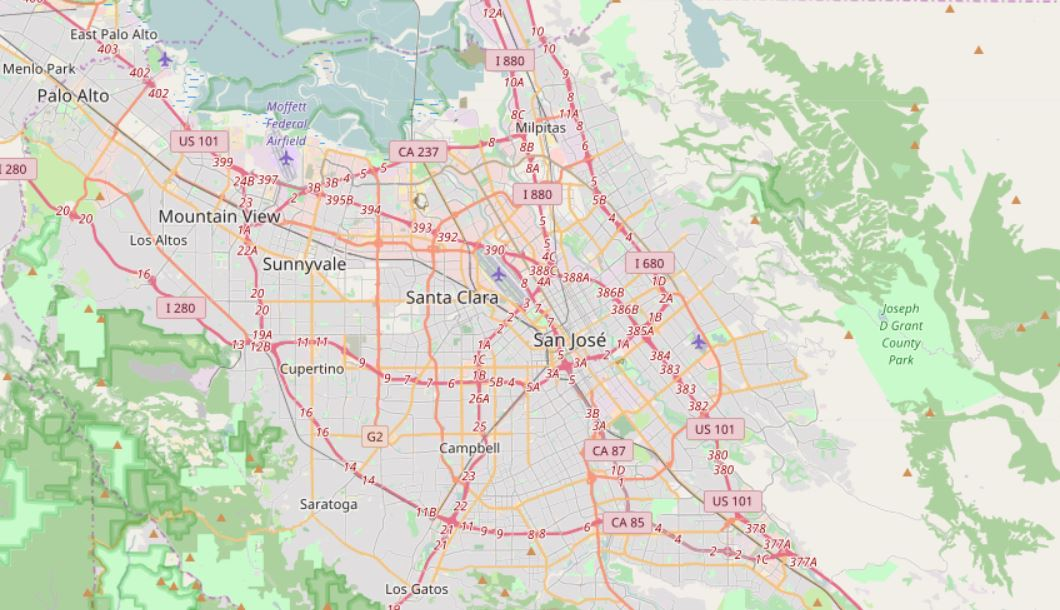

In [4]:
from IPython.display import Image
Image("san_jose.jpg")

## Data Wrangling


In [5]:
import xml.etree.cElementTree as ET
from collections import defaultdict
import re
import pprint


In [6]:
# import the osm file
OSMFILE = "san-jose_california.osm"


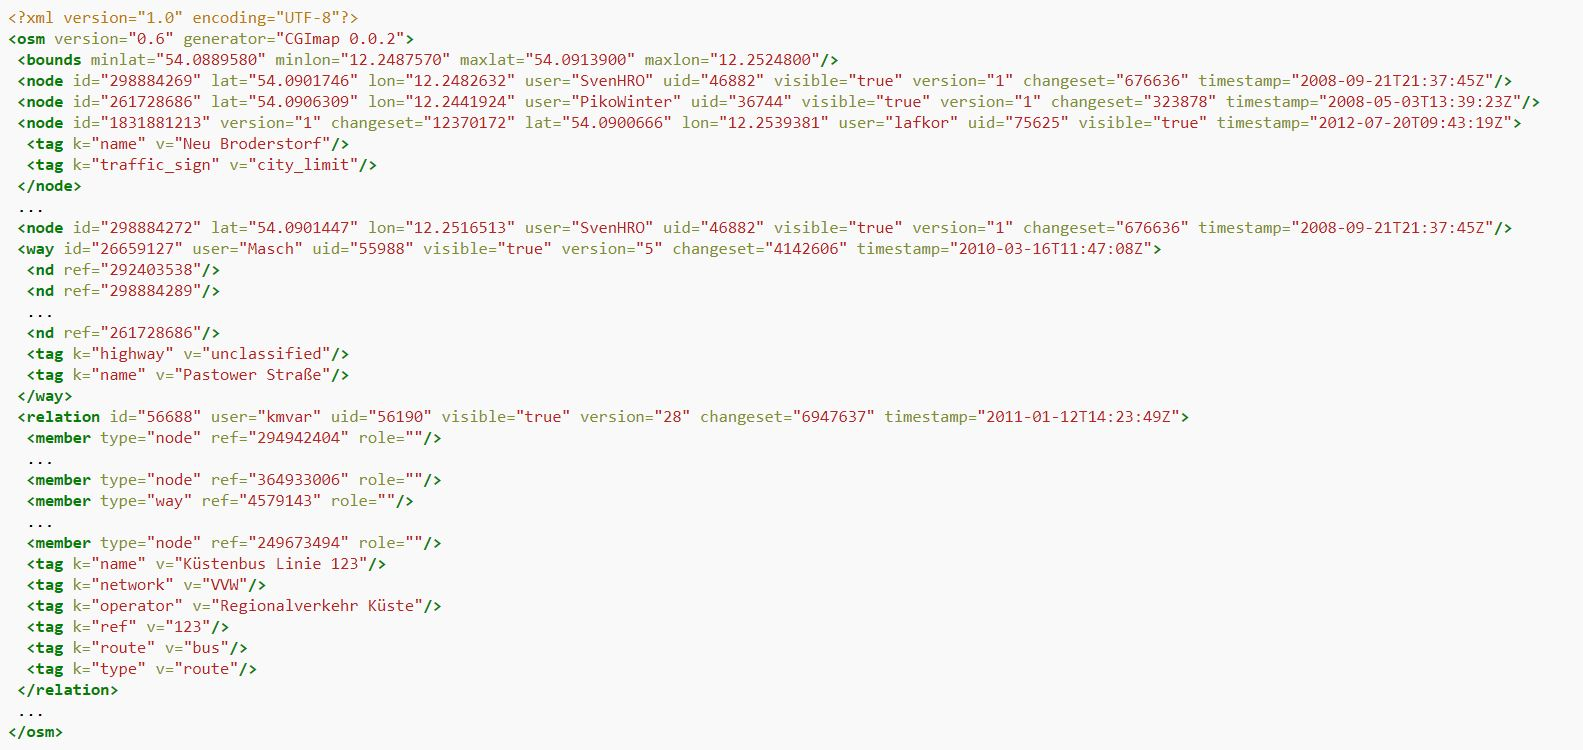

In [7]:
Image("osm.jpg")


In [8]:
# Dictionary of tag name and the number of times the tag can be encountered 
def count_tags(filename):
        tags = defaultdict(int)
        tree = ET.parse(filename)
        root = tree.getroot()
        for element in root.iter():
            tags[element.tag] += 1
        return tags
    
count_tags(OSMFILE)


defaultdict(int,
            {'bounds': 1,
             'member': 14912,
             'nd': 1867751,
             'node': 1603301,
             'osm': 1,
             'relation': 1537,
             'tag': 738829,
             'way': 212008})

This size of the osm file is 341MB and it contains:

Parent elements: 
- node: 1603301
- way: 212008

Child elements:
- tag: 738829
- nd: 1867751

In [9]:
# exploring the number of unique users
def process_map(filename):
    users = set()
    count = 0
    for _, element in ET.iterparse(filename):
        users.add(get_user(element))
        users.discard(None)
        count = len(users)
    return users,count

def get_user(element):
    if element.tag == "node" or element.tag == "way" or element.tag == "relation":
        uid = element.get('uid')
        return uid

user_set, num_in_set = process_map(OSMFILE)
print "Number of Unique Users: ", num_in_set


Number of Unique Users:  1368


And this map has 1368 users.

## Problems Encountered
The formate of the values are inconsistent. For examlpe, some of the street names are overabbreviated (i.e., "Fountain Oaks Dr") and some of the zipcodes contain the State (i.e., "CA 95054"). 


### Street Name Standardization

In [10]:
# Cleaning the street value
street_type_re = re.compile(r'\b\S+\.?$', re.IGNORECASE)

expected = ["Street", "Avenue", "Boulevard", "Drive", "Court", "Place", "Square", "Lane", "Road", 
            "Trail", "Parkway", "Commons"]

# Street Abbreviations
mapping = {"St": "Street",
            "St.": "Street",
            "ST": "Street",
            "STREET": "Street",
            "Ave": "Avenue",
            "Ave.": "Avenue",
            "Rd.": "Road",
            "Dr.": "Drive",
            "Dr": "Drive",
            "Ln": "Lane",
            "Rd": "Road",
            "Rd.": "Road",
            "Blvd": "Boulevard",
            "Blvd.": "Boulevard",
            "Trl": "Trail",
            "Cir": "Circle",
            "Cir.": "Circle",
            "Ct": "Court",
            "Ct.": "Court",
            "Crt": "Court",
            "Crt.": "Court",
            "Sq": "Square",
            "Hwy": "Highway"
            }

def audit_street_type(street_types, street_name):
    m = street_type_re.search(street_name)
    if m:
        street_type = m.group()
        if street_type not in expected:
            street_types[street_type].add(street_name)
    return street_types

def is_street_name(elem):
    return (elem.attrib['k'] == "addr:street")

def audit(osmfile):
    osm_file = open(osmfile, "r")
    street_types = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):

        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_street_name(tag):
                    audit_street_type(street_types, tag.attrib['v'])
    osm_file.close()
    return street_types

def update_name(name, mapping):
    m = street_type_re.search(name)
    better_name = name
    # condition: if the street name does have a last word
    if m:
        # check if the street type is a key in your mapping dictionary:
        if m.group() in mapping.keys():
            better_street_type = mapping[m.group()]
            better_name = street_type_re.sub(better_street_type, name)
    return better_name


In [11]:
street_type_set = audit(OSMFILE)

def better_name():
    for st_type, ways in street_type_set.iteritems():
        for name in ways:
            better_name = update_name(name, mapping)
            name = better_name
better_name()      

Streets with overabbreviated name will be updated. 
For example:
- Casa Verde St => Casa Verde Street
- Perivale Ct => Perivale Court
- Celadon Cir => Celadon Circle


### Zipcode Standardization

In [12]:
# zipcode standization
zipcode_type_re = re.compile(r'^\D*(\d{5}).*')

def audit_zipcode_type(zipcode_type, zipcode):
    first_two_char = zipcode[0:2]
    if first_two_char.isdigit():
        zipcode_type[first_two_char].add(zipcode)
    else:
        zipcode_type[first_two_char].add(zipcode)
    return zipcode_type

def is_zipcode(elem):
    return (elem.attrib['k'] == "addr:postcode")

def audit_zipcode(osmfile):
    osm_file = open(osmfile, "r")
    invalid_zipcode_type = defaultdict(set)
    for event, elem in ET.iterparse(osm_file, events=("start",)):
        if elem.tag == "node" or elem.tag == "way":
            for tag in elem.iter("tag"):
                if is_zipcode(tag):
                    audit_zipcode_type(invalid_zipcode_type, tag.attrib['v'])
    osm_file.close()
    return invalid_zipcode_type

def update_zipcode(zipcode):
    first_two_char = zipcode[0:2]
    better_zipcode = ""
    if first_two_char == "CA":
        better_zipcode += zipcode[2:8]
    else:
        better_zipcode = zipcode
    return better_zipcode


In [13]:
zipcode_type_set = audit_zipcode(OSMFILE)


In [14]:
for zipcode_type, ways in zipcode_type_set.iteritems():
    for code in ways:
        better_zipcode = update_zipcode(code)
        code = better_zipcode
        

Zipcodes with inconsistent format will be updated. 
For example:
- CA 95054 => 95954
- CA 94035 => 94035


## SQL Database Files Perparation
After completed auditing, the data will be prepared to be inserted into a SQL database. The elements in the OSM XML file will be parsed and transformed to tabular format and write to .csv files. These csv files will be imported to a SQL database as tables.


In [15]:
#SQL database files perparation
# schema 
schema = {
    'node': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'lat': {'required': True, 'type': 'float', 'coerce': float},
            'lon': {'required': True, 'type': 'float', 'coerce': float},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'node_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    },
    'way': {
        'type': 'dict',
        'schema': {
            'id': {'required': True, 'type': 'integer', 'coerce': int},
            'user': {'required': True, 'type': 'string'},
            'uid': {'required': True, 'type': 'integer', 'coerce': int},
            'version': {'required': True, 'type': 'string'},
            'changeset': {'required': True, 'type': 'integer', 'coerce': int},
            'timestamp': {'required': True, 'type': 'string'}
        }
    },
    'way_nodes': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'node_id': {'required': True, 'type': 'integer', 'coerce': int},
                'position': {'required': True, 'type': 'integer', 'coerce': int}
            }
        }
    },
    'way_tags': {
        'type': 'list',
        'schema': {
            'type': 'dict',
            'schema': {
                'id': {'required': True, 'type': 'integer', 'coerce': int},
                'key': {'required': True, 'type': 'string'},
                'value': {'required': True, 'type': 'string'},
                'type': {'required': True, 'type': 'string'}
            }
        }
    }
}


In [16]:
import csv
import codecs
import re
import cerberus

OSM_PATH = "san-jose_california.osm"

NODES_PATH = "nodes.csv"
NODE_TAGS_PATH = "nodes_tags.csv"
WAYS_PATH = "ways.csv"
WAY_NODES_PATH = "ways_nodes.csv"
WAY_TAGS_PATH = "ways_tags.csv"

LOWER_COLON = re.compile(r'^([a-z]|_)+:([a-z]|_)+')
PROBLEMCHARS = re.compile(r'[=\+/&<>;\'"\?%#$@\,\. \t\r\n]')

SCHEMA = schema

# Make sure the fields order in the csvs matches the column order in the sql table schema
NODE_FIELDS = ['id', 'lat', 'lon', 'user', 'uid', 'version', 'changeset', 'timestamp']
NODE_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_FIELDS = ['id', 'user', 'uid', 'version', 'changeset', 'timestamp']
WAY_TAGS_FIELDS = ['id', 'key', 'value', 'type']
WAY_NODES_FIELDS = ['id', 'node_id', 'position']


def shape_element(element, node_attr_fields=NODE_FIELDS, way_attr_fields=WAY_FIELDS,
                  problem_chars=PROBLEMCHARS, default_tag_type='regular'):
    """Clean and shape node or way XML element to Python dict"""

    node_attribs = {}
    way_attribs = {}
    way_nodes = []
    node_tags = []
    way_tags = []

    if element.tag == 'node':
        for attrib in element.attrib:
            if attrib in node_attr_fields:
                node_attribs[attrib] = element.attrib[attrib]
    
    
        for child in element:
            if child.tag == "tag" and problem_chars.match(child.attrib['k']) == None:
                #for attrib in child.attrib:
                tag = {}
                tag['id'] = element.attrib['id']
                key = child.attrib['k']
                tag['key'] = key[key.find(':')+1:]
                
                #update the street name and zipcode
                if child.attrib["k"] == 'addr:street':
                    tag["value"] = update_name(child.attrib["v"], mapping)
                elif child.attrib["k"] == 'addr:postcode':
                    tag["value"] = update_zipcode(child.attrib["v"])
                else:   
                    tag['value'] = child.attrib['v']
                
                if key.find(':') == -1:
                    tag['type'] = default_tag_type
                else:
                    tag['type'] = key[:key.find(':')]
                node_tags.append(tag)

        return {'node': node_attribs, 'node_tags': node_tags}
    
    elif element.tag == 'way':
        for attrib in element.attrib:
            if attrib in way_attr_fields:
                way_attribs[attrib] = element.attrib[attrib]
    
        position = 0
        for child in element:
            if child.tag == "nd":
                way_node = {}
                way_node['id'] = element.attrib['id']
                way_node['node_id'] = child.attrib['ref']
                way_node['position'] = position
                position += 1
                
                way_nodes.append(way_node)
            
            if child.tag == "tag" and problem_chars.match(child.attrib['k']) == None:
                tag = {}
                tag['id'] = element.attrib['id']
                key = child.attrib['k']
                tag['key'] = key[key.find(':')+1:]
                
                #update the street name and zipcode
                if child.attrib["k"] == 'addr:street':
                    tag["value"] = update_name(child.attrib["v"], mapping)
                elif child.attrib["k"] == 'addr:postcode':
                    tag["value"] = update_zipcode(child.attrib["v"])
                else:   
                    tag['value'] = child.attrib['v']
                
                if key.find(':') == -1:
                    tag['type'] = default_tag_type
                else:
                    tag['type'] = key[:key.find(':')]
                way_tags.append(tag)
    
        return {'way': way_attribs, 'way_nodes': way_nodes, 'way_tags': way_tags}

# helper functions
def get_element(osm_file, tags=('node', 'way', 'relation')):
    """Yield element if it is the right type of tag"""

    context = ET.iterparse(osm_file, events=('start', 'end'))
    _, root = next(context)
    for event, elem in context:
        if event == 'end' and elem.tag in tags:
            yield elem
            root.clear()

def validate_element(element, validator, schema=SCHEMA):
    """Raise ValidationError if element does not match schema"""
    if validator.validate(element, schema) is not True:
        field, errors = next(validator.errors.iteritems())
        message_string = "\nElement of type '{0}' has the following errors:\n{1}"
        error_string = pprint.pformat(errors)
        
        raise Exception(message_string.format(field, error_string))

class UnicodeDictWriter(csv.DictWriter, object):
    """Extend csv.DictWriter to handle Unicode input"""

    def writerow(self, row):
        super(UnicodeDictWriter, self).writerow({
            k: (v.encode('utf-8') if isinstance(v, unicode) else v) for k, v in row.iteritems()
        })

    def writerows(self, rows):
        for row in rows:
            self.writerow(row)

# main function
def process_map(file_in, validate):
    """Iteratively process each XML element and write to csv(s)"""

    with codecs.open(NODES_PATH, 'w') as nodes_file, \
         codecs.open(NODE_TAGS_PATH, 'w') as nodes_tags_file, \
         codecs.open(WAYS_PATH, 'w') as ways_file, \
         codecs.open(WAY_NODES_PATH, 'w') as way_nodes_file, \
         codecs.open(WAY_TAGS_PATH, 'w') as way_tags_file:

        nodes_writer = UnicodeDictWriter(nodes_file, NODE_FIELDS)
        node_tags_writer = UnicodeDictWriter(nodes_tags_file, NODE_TAGS_FIELDS)
        ways_writer = UnicodeDictWriter(ways_file, WAY_FIELDS)
        way_nodes_writer = UnicodeDictWriter(way_nodes_file, WAY_NODES_FIELDS)
        way_tags_writer = UnicodeDictWriter(way_tags_file, WAY_TAGS_FIELDS)

        nodes_writer.writeheader()
        node_tags_writer.writeheader()
        ways_writer.writeheader()
        way_nodes_writer.writeheader()
        way_tags_writer.writeheader()

        validator = cerberus.Validator()

        for element in get_element(file_in, tags=('node', 'way')):
            el = shape_element(element)
            if el:
                if validate is True:
                    validate_element(el, validator)
                
                if element.tag == 'node':
                    nodes_writer.writerow(el['node'])
                    node_tags_writer.writerows(el['node_tags'])
                elif element.tag == 'way':
                    ways_writer.writerow(el['way'])
                    way_nodes_writer.writerows(el['way_nodes'])
                    way_tags_writer.writerows(el['way_tags'])


In [17]:
# Convert the osm file to csv files
process_map(OSMFILE, validate=False)


In [18]:
files = ['nodes.csv','ways.csv', 'ways_tags.csv', 'nodes_tags.csv', 'ways_nodes.csv']

def remove_extra_lines(files):
    for filename in files:
        with open('{}_{}'.format('new',filename), 'w') as f_out:
            for line in open(filename):
                line = line.rstrip()
                if line != '':
                    line = line + '\n'
                    f_out.write(line)
remove_extra_lines(files)

### Challenges Encountered During the Wrangling
There are 2 different parent elements ("node" and "way") and each of them contains different number of child elements. For example, the parent element "node" contains 1 child element, "tag"; while the another parent element "way" contains 2 child elements, "node" and "tag". And some information may be contained in the child element of both parent elements. So a decent amount of time and effort has been put to understand the structure of the data and write fuctions to iterate thru these elements to export and import data from the OSM file. 


## SQL Database Creation
----------------------------------------------------------SQL codes----------------------------------------------------------
### Create a new database
    Sqlite3 map.db

### Build the schemas
    CREATE TABLE nodes (id INTEGER PRIMARY KEY, lat REAL, lon REAL, user TEXT, uid INTEGER, version INTEGER, changeset INTEGER, timestamp TEXT);
    CREATE TABLE nodes_tags(id INTEGER NOT NULL, key TEXT , value TEXT, type TEXT, FOREIGN KEY (id) REFERENCES nodes(id));  
    CREATE TABLE ways (id INTEGER PRIMARY KEY NOT NULL, user TEXT, uid INTEGER, version TEXT, changeset INTEGER, timestamp TEXT);
    CREATE TABLE ways_tags (id INTEGER NOT NULL, key TEXT, value TEXT, type TEXT, FOREIGN KEY (id) REFERENCES ways(id));
    CREATE TABLE ways_nodes (id INTEGER NOT NULL, node_id INTEGER, position INTEGER, FOREIGN KEY (id) REFERENCES WAYS(id), FOREIGN KEY (node_id) REFERENCES nodes(id));

#View the list of tables created
    
    .tables

### Import data from CSV to database
    .mode csv
    .import new_nodes.csv nodes
    .import new_nodes_tags.csv nodes_tags
    .import new_ways.csv ways
    .import new_ways_tags.csv ways_tags
    .import new_ways_nodes.csv ways_nodes
   
-------------------------------------------------------------End-------------------------------------------------------------


## Exploring the Database

### Size of the files

In [16]:
# get files' size
from pprint import pprint
import os
from hurry.filesize import size

dirpath = 'C:/Users/Suen/Desktop/Spring 17/Data Analysis Nanodegree/p3-DataWranglingWithSQL/files'

files_list = []
filenames_list = []
sizes_list =[]
for path, dirs, files in os.walk(dirpath):
    files_list.extend([(filename, size(os.path.getsize(os.path.join(path, filename)))) for filename in files])

for filename, size in files_list:
    filenames_list.append(filename)
    sizes_list.append(size)
    
import pandas as pd
sizes_table = pd.DataFrame({"Size": sizes_list}, index = filenames_list)
print "Size of the Files"
print sizes_table


Size of the Files
                         Size
map.db                   308M
new_nodes.csv            127M
new_nodes_tags.csv         2M
new_ways.csv              11M
new_ways_nodes.csv        42M
new_ways_tags.csv         21M
san-jose_california.osm  333M


### Connect to the Database and Cursor

In [17]:
# connect to the database and cursor
import sqlite3
conn = sqlite3.connect("map.db")
cursor = conn.cursor()


In [18]:
# number of nodes 
query = "SELECT COUNT(*) FROM nodes;"
cursor.execute(query)
node_result = cursor.fetchall()
conn.commit()
print "Number of nodes:", node_result[0][0]

# number of ways
query = "SELECT COUNT(*) FROM ways;"
cursor.execute(query)
way_result = cursor.fetchall()
conn.commit()
print "Number of ways:", way_result[0][0]


Number of nodes: 1603301
Number of ways: 212008


There are 1603301 nodes and 212008 ways.

In [19]:
# number of unique users
query = "SELECT COUNT(DISTINCT(uid)) FROM (SELECT uid FROM nodes UNION All SELECT uid FROM ways);"
cursor.execute(query)
result = cursor.fetchall()
conn.commit()
print "Number of unique users: ",(result[0][0])

Number of unique users:  1359


In [20]:
# top 10 contributing users 
query = '''SELECT user, COUNT(*) as num FROM 
           (SELECT user FROM nodes UNION ALL SELECT user FROM ways) 
           GROUP BY user ORDER BY num DESC LIMIT 10;'''
cursor.execute(query)
result = cursor.fetchall()
conn.commit()

# table
user_name_list = []
contributions_list = []
index_list = range(1, 11)
count = 0
for name, number in result:
    user_name_list.append(name)
    contributions_list.append(number)
for number in contributions_list:
    count += number
import pandas as pd
top_contributors_table = pd.DataFrame({"Name of the User:": user_name_list, 
                                       "Number of Contributions:": contributions_list}, index = index_list)
print "Top 10 coontributing users"
print top_contributors_table

print "Number of contributions made by this top 10 users:", count


Top 10 coontributing users
   Name of the User:  Number of Contributions:
1            andygol                    296236
2            nmixter                    286554
3              mk408                    151032
4        Bike Mapper                     84175
5             samely                     77706
6          dannykath                     71938
7           RichRico                     71823
8           karitotp                     57133
9       MustangBuyer                     49901
10               n76                     37902
Number of contributions made by this top 10 users: 1184400


In [21]:
# Number of users made 10 or less contribution 
query = '''SElECT COUNT(*) FROM (SELECT user, COUNT(*) AS NUM FROM 
           (SELECT user FROM nodes UNION ALL SELECT user FROM ways)
           GROUP BY user HAVING NUM < 10);'''
cursor.execute(query)
result = cursor.fetchall()
conn.commit()
print "Number of users that made 10 or less contribution: ",(result[0][0])

Number of users that made 10 or less contribution:  680


 There are 1359 users. The top 3 contributing users have made 296236, 286554 and 151032 contributions. The total contributions made by the top ten users is 2240113. And although there are 1359 users, 680 users made only 10 or less contribution. Therefore, there is a big imbalance in the number of contributions made by the users. 

In [22]:
# top 10 amenities
query = '''SELECT value, COUNT(*) as num FROM nodes_tags 
           WHERE key = 'amenity' GROUP BY value ORDER BY num DESC LIMIT 10;'''
cursor.execute(query)
result = cursor.fetchall()
conn.commit()

# table
amenities_list = []
updates_list = []
for amenities, updates in result:
    amenities_list.append(amenities)
    updates_list.append(updates)

print "Top Amenities"
top_amenities_table = pd.DataFrame({"Number of Updates:": updates_list}, index = amenities_list)
print top_amenities_table


Top Amenities
                  Number of Updates:
restaurant                       807
fast_food                        389
bench                            237
cafe                             236
place_of_worship                 186
bicycle_parking                  176
toilets                          152
school                           149
fuel                             127
bank                             118


The amenities that have the most updates are restaurant, fast food and bench. 

In [23]:
# top 10 shop types
query = '''SELECT value, COUNT(*) as num FROM nodes_tags 
           WHERE key = 'shop' GROUP BY value ORDER BY num DESC LIMIT 10;'''
cursor.execute(query)
result = cursor.fetchall()
conn.commit()

# table
shops_list = []
updates_list = []
for shops, updates in result:
    shops_list.append(shops)
    updates_list.append(updates)

print "Top Shop Types"
top_shops_table = pd.DataFrame({"Number of Updates:": updates_list}, index = shops_list)
print top_shops_table

Top Shop Types
              Number of Updates:
supermarket                  109
beauty                       105
clothes                      102
hairdresser                  100
car_repair                    82
convenience                   77
bakery                        42
alcohol                       36
jewelry                       36
mobile_phone                  35


The types of shop that have the most updates are supermarket, beauty and clothes.

In [25]:
conn.close()

## Improvement ideas
The format of the data is inconsistent. For example, some of the street names are overabbreviated (i.e., "Fountain Oaks Dr") and some of the zipcodes contain the State (i.e., "CA 95054"). In order to increase the consistency of the data, the form the contributors used to make contributions should includes some restrictions. Such as limiting the contributors to enter intergers only when they are inputing the zipcode, or add an reminder to remind contributors not to use abbrevaited street name on top of the text box used to enter the street names. This method should be a quick fix and it can keep the data more consistent and cleaner for analysis.

Furthermore, there are 1359 users and 1815309 contributions. However, most(65.25%) of the contributions are made by the top 10 users. And 680 users made only 10 ore less contributions. In order to keep the map more complete, up to date and more accuarate, one sugguestion is to motivate the users to contribute more frequently. For example, OpenStreetMap can provide a small incentivate to contributors who make a certain amount of contributions. However, this method may not be ideal as OpenStreetMap is a non-profit foundation and implementing this method may create a finanical burden to it. Another method may be sending emails to thanks the contributors for their contributions and continuously providing them updates made by other contributors on the area they have once contributed to. This may be able to increase the exposure rate of OpenStreetMap and simulate the contributors' interest in making more contributions. More importantly, this method is relatively cheaper than the previous method. 

## Reference
- OpenStreetMap Wiki: https://wiki.openstreetmap.org/wiki/OSM_XML

- Udacity course- Data Wrangling: https://www.udacity.com/course/data-analyst-nanodegree--nd002
- Tutorials Point- Learn SQL: https://www.tutorialspoint.com/sql/sql-select-query.htm